In [45]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import random
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torchvision.transforms import v2

from typing import List, Literal

import cv2

import matplotlib.pyplot as plt

import timm

import gc



In [46]:
N = 224
N_CLASSES = 2
SMOOTH = 0.1
LOSS = 'CE' # CE or UANLL
SEED = [42, 0, 17, 9, 3]
NUM_TTA_FOR_SEED = 10
TRAIN = True
EPOCHS = 1

CONFIG = dict(
    backbone = "tf_efficientnetv2_s", # , resnet18, tf_efficientnet_b0.ns_jft_in1k
    drop_rate = 0,
    drop_rate_last = 0.3,
    drop_rate_path = 0.,
    device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
)


In [47]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    pl.seed_everything(seed)
    g = torch.Generator()
    g.manual_seed(seed)
    return g
    
    
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [48]:
from torchvision.transforms import ToTensor

class ClassDataset(Dataset):
    def __init__(self, dataframe, preload_transform=None, transform=None):
        self.dataframe = dataframe
        self.preload_transform = preload_transform
        self.transform = transform

        self.images = torch.zeros(len(dataframe), 3, N, N).float()

        for idx in range(len(dataframe)):
            image_path = self.dataframe.index[idx]
            image = Image.open(f'images/{image_path}').convert("RGB")
            if self.preload_transform:
                self.images[idx] = self.preload_transform(image)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.images[idx]), int(self.dataframe.loc[self.dataframe.index[idx], 'CTI_label'])
        else:
            return self.images[idx], int(self.dataframe.loc[self.dataframe.index[idx], 'CTI_label'])

class ISICDataset(Dataset):
    def __init__(self,
                 dataframe: pd.DataFrame,
                 img_dir: str,
                 transform: List = None):
        """
        Dataset class for loading ISIC Balanced Dataset
        Can be downloaded via kaggle api: olegopoly/isic-balanced
        
        Args:
            dataframe (pd.DataFrame): DataFrame containing the isic_id and target columns.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        isic_id = self.dataframe.iloc[idx]['isic_id']
        target = self.dataframe.iloc[idx]['target']        
        img_name = os.path.join(self.img_dir, f"{isic_id}.jpg")
        
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image=image)['image']
        
        # Convert image to PyTorch tensor
        image = ToTensor()(image)
        
        # Convert target to long tensor
        target = torch.tensor(target, dtype=torch.long)
        
        return image, target


### Transforms

In [49]:
import albumentations as A

transforms = {'train' :  A.Compose([
        A.Transpose(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=(-25, 25), p=0.5), 
        
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
        
        A.OneOf([
            A.MotionBlur(blur_limit=5),
            A.MedianBlur(blur_limit=5),
            A.GaussianBlur(blur_limit=5),
            A.GaussNoise(var_limit=(5.0, 30.0))
        ], p=0.7),
        
        A.OneOf([
            A.OpticalDistortion(distort_limit=1.0),
            A.GridDistortion(num_steps=5, distort_limit=1.0),
            A.ElasticTransform(alpha=3),
        ], p=0.7),
        
        A.CLAHE(clip_limit=4.0, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.5),
        
        A.Resize(height=N, width=N, p=1.0),
        A.CoarseDropout(max_holes=5, max_height=int(N * 0.15), max_width=int(N * 0.15), p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225], 
                    max_pixel_value=255.0, p=1)
    ]),
    
    'valid' : A.Compose([
        A.Resize(height=N, width=N, p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225], 
                    max_pixel_value=255.0, p=1)
    ]),

    'tta' : A.Compose([
        
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
        A.OneOf([
            A.MotionBlur(blur_limit=5),
            A.MedianBlur(blur_limit=5),
            A.GaussianBlur(blur_limit=5),
            A.GaussNoise(var_limit=(5.0, 30.0))
        ], p=0.7),
        A.OneOf([
            A.OpticalDistortion(distort_limit=1.0),
            A.GridDistortion(num_steps=5, distort_limit=1.0),
            A.ElasticTransform(alpha=3),
        ], p=0.7),
        A.CLAHE(clip_limit=4.0, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.5),
        A.Resize(height=N, width=N, p=1.0),
        A.CoarseDropout(max_holes=5, max_height=int(N * 0.15), max_width=int(N * 0.15), p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225], 
                    max_pixel_value=255.0, p=1)
    ])

    }

/root/miniconda/envs/cxr/lib/python3.12/site-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


In [50]:
dataframe = pd.read_csv('data/dataset.csv')

dataset = ISICDataset(dataframe, 'data/images', transform=transforms['valid'])

In [51]:
iterator = iter(dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151553..2.378562].


Image of class 1
Image size torch.Size([3, 224, 224])


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

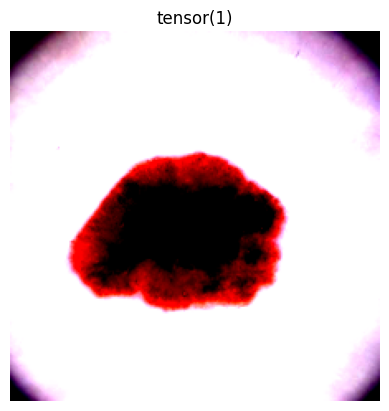

In [52]:
image, label = next(iterator)

print(f'Image of class {label}')
print(f'Image size {image.size()}')

plt.imshow(image.permute(1, 2, 0))
plt.title(label)
plt.axis('off')

In [53]:
df = pd.read_csv('data/dataset.csv')
df['target'] = df['target'].astype(int)

In [54]:
df

,isic_id,patient_id,path,target,target_eva02,binned_target,new_path
0,ISIC_0034246,HAM_0000002,/kaggle/input/isic-2018-jpg-256x256-resized/tr...,1,NaN,NaN,/kaggle/input/isic-balanced/images/ISIC_003424...
1,ISIC_0034162,HAM_0000006,/kaggle/input/isic-2018-jpg-256x256-resized/tr...,1,NaN,NaN,/kaggle/input/isic-balanced/images/ISIC_003416...
2,ISIC_0031377,HAM_0000022,/kaggle/input/isic-2018-jpg-256x256-resized/tr...,1,NaN,NaN,/kaggle/input/isic-balanced/images/ISIC_003137...
3,ISIC_0027190,HAM_0000040,/kaggle/input/isic-2018-jpg-256x256-resized/tr...,1,NaN,NaN,/kaggle/input/isic-balanced/images/ISIC_002719...
4,ISIC_0034048,HAM_0000042,/kaggle/input/isic-2018-jpg-256x256-resized/tr...,1,NaN,NaN,/kaggle/input/isic-balanced/images/ISIC_003404...
...,...,...,...,...,...,...,...
11665,ISIC_0357088,IP_0541183,/kaggle/input/isic-2024-challenge/train-image/...,0,0.472632,"(0.4, 0.6]",/kaggle/input/isic-balanced/images/ISIC_035708...
11666,ISIC_5942709,IP_1249536,/kaggle/input/isic-2024-challenge/train-image/...,0,0.043596,"(-0.001, 0.2]",/kaggle/input/isic-balanced/images/ISIC_594270...
11667,ISIC_2396598,IP_7797815,/kaggle/input/isic-2024-challenge/train-image/...,0,0.788677,"(0.6, 0.8]",/kaggle/input/isic-balanced/images/ISIC_239659...
11668,ISIC_5997955,IP_5638421,/kaggle/input/isic-2024-challenge/train-image/...,0,0.989144,"(0.8, 1.0]",/kaggle/input/isic-balanced/images/ISIC_599795...


In [55]:
train_df, val_test_df = train_test_split(df, test_size=0.4, stratify=df['target'], random_state=42)

In [56]:
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['target'], random_state=42)

### Data Module

In [57]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

class ISICDataModule(pl.LightningDataModule):
    def __init__(self, csv_file,
                 img_dir: str,
                 transform: bool = None,
                 batch_size: int = 32,
                 num_workers: int = 4,
                 is_tta: bool = False):
        '''
        Data Module for ISISC Balanced dataset
        `is_tta` flag ensures transforms for test time augmentations are being used
        '''
        super().__init__()
        self.csv_file = csv_file
        self.img_dir = img_dir
        self.transform = transform
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.is_tta = is_tta

    def setup(self, stage=None):
        df = pd.read_csv(self.csv_file)
        df['target'] = df['target'].astype(int)
        train_df, val_test_df = train_test_split(df, test_size=0.4, stratify=df['target'], random_state=42)
        val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['target'], random_state=42)
        
        self.train_dataset = ISICDataset(train_df, self.img_dir, transform=self.transform['train'])
        self.val_dataset = ISICDataset(val_df, self.img_dir, transform=self.transform['valid'])
        if self.is_tta == False:
            self.test_dataset = ISICDataset(test_df, self.img_dir, transform=self.transform['valid'])
        else:
            self.test_dataset = ISICDataset(test_df, self.img_dir, transform=self.transform['tta'])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

In [58]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(512 * 14 * 14, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 2 if LOSS == 'CE' else 3)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def gem(x, p=3, eps=1e-4):
    return F.avg_pool2d(x.clamp(min=eps), (x.size(-2), x.size(-1))).pow(1.0 / p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6, p_trainable=False):
        super(GeM, self).__init__()
        if p_trainable:
            self.p = Parameter(torch.ones(1) * p)
        else:
            self.p = p
        self.eps = eps


    def forward(self, x):
        ret = gem(x, p=self.p, eps=self.eps)
        return ret
    

class ISICModel(nn.Module):
    def __init__(self,
                 backbone: str = CONFIG['backbone'],
                 loss: Literal['CE', 'UANLL'] = LOSS,
                 pretrained: bool = False):
        '''
        Model with adaptive output FC for using with UANLL Loss
        ! Uses external variable `LOSS`
        '''
        super(ISICModel, self).__init__()
        self.encoder = timm.create_model(
            backbone,
            in_chans=3,
            drop_rate=CONFIG['drop_rate'],
            drop_path_rate=CONFIG['drop_rate_path'],
            pretrained=pretrained,
        )
        
        self.nb_fts = self.encoder.num_features
        self.gap = nn.AdaptiveAvgPool2d(1)

        if loss == 'UANLL':
            self.out_chans = 3
        else:
            self.out_chans = 2

        self.head = nn.Sequential(
                        nn.Linear(self.nb_fts, 128),
                        nn.BatchNorm1d(128),
                        nn.Dropout(CONFIG["drop_rate_last"]),
                        nn.LeakyReLU(0.1),
                        nn.Linear(128, self.out_chans),
                    )
        
    def forward(self, x):
        feat = self.encoder.forward_features(x)
        feat = self.gap(feat)[:,:,0,0]
        y = self.head(feat)
        
        return y
    
    def freeze_encoder(self, flag):
        for param in self.encoder.parameters():
            param.requires_grad = not flag
            
    
class UANLLloss(nn.Module):
    def __init__(self, smoothing=SMOOTH, classes=N_CLASSES):
        super(UANLLloss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.clc = classes
        
    def forward(self,x,y):
        logvar  = (x[:,self.clc:]) #** 2 
        prob = x[:,:self.clc]

        with torch.no_grad():
            yoh = torch.zeros_like(prob)
            yoh.fill_(self.smoothing / (self.clc - 1))
            yoh.scatter_(1, y.data.unsqueeze(1), self.confidence)

        loss0 = ((yoh - prob) ** 2).sum(dim=1)
        loss = (torch.exp(-logvar) * loss0 + self.clc * logvar)

        return loss.mean()
    
class ClassModel(pl.LightningModule):
    def __init__(self):
        super(ClassModel, self).__init__()
        self.model = ISICModel(backbone='tf_efficientnetv2_s')
        self.criterion = UANLLloss() if LOSS == 'UANLL' else nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        sm = nn.functional.softmax(outputs, dim=1)
        acc = (sm.argmax(1) == targets).sum() / len(targets)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return {'val_loss': loss, 'val_acc': acc}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-4)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 16 * 50, gamma=0.5, last_epoch=-1, verbose=0)
        # return [optimizer], [scheduler]
        return optimizer



In [59]:
checkpoints = []

datamodule = ISICDataModule(csv_file='data/dataset.csv', img_dir='data/images', transform=transforms, batch_size=32, num_workers=0)

datamodule.setup()

train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()
test_loader = datamodule.test_dataloader()

if TRAIN:
    for seed in SEED:
        g = seed_everything(seed)

        train_loader = datamodule.train_dataloader()
        val_loader = datamodule.val_dataloader()

        checkpoint_callback = ModelCheckpoint(
            monitor='val_loss',
            dirpath='checkpoints/encoder',
            filename = f'enetv2s_{LOSS}_{seed}_' + '{epoch:02d}-{val_acc:.2f}',
            save_top_k=1,
            mode='min',
        )

        logger = TensorBoardLogger("tb_logs", name=f'class_{LOSS}_{seed}')

        model = ClassModel()

        trainer = pl.Trainer(
            max_epochs=EPOCHS,
            callbacks=[checkpoint_callback],
            logger=logger,
            deterministic=True
        )

        trainer.fit(model, train_loader, val_loader)
        checkpoints.append(checkpoint_callback.best_model_path)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/root/miniconda/envs/cxr/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /repo/tta_class/checkpoints/encoder exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ISICModel        | 21.6 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
21.6 M    Trainable params
0         Non-trainable params
21.6 M    Total params
86.492    Total estimated model params size (MB)
699       Modules in train mode
0         Modules in eval mode


/root/miniconda/envs/cxr/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/root/miniconda/envs/cxr/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/219 [00:00<?, ?it/s] 

Epoch 0: 100%|██████████| 219/219 [00:52<00:00,  4.14it/s, v_num=22, val_loss=0.247, val_acc=0.910]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 219/219 [00:53<00:00,  4.09it/s, v_num=22, val_loss=0.247, val_acc=0.910]


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ISICModel        | 21.6 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
21.6 M    Trainable params
0         Non-trainable params
21.6 M    Total params
86.492    Total estimated model params size (MB)
699       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 219/219 [00:54<00:00,  4.05it/s, v_num=1, val_loss=0.241, val_acc=0.916]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 219/219 [00:54<00:00,  4.01it/s, v_num=1, val_loss=0.241, val_acc=0.916]


Seed set to 17
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ISICModel        | 21.6 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
21.6 M    Trainable params
0         Non-trainable params
21.6 M    Total params
86.492    Total estimated model params size (MB)
699       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 219/219 [00:54<00:00,  4.00it/s, v_num=1, val_loss=0.261, val_acc=0.909]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 219/219 [00:55<00:00,  3.96it/s, v_num=1, val_loss=0.261, val_acc=0.909]


Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ISICModel        | 21.6 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
21.6 M    Trainable params
0         Non-trainable params
21.6 M    Total params
86.492    Total estimated model params size (MB)
699       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 219/219 [00:54<00:00,  4.03it/s, v_num=1, val_loss=0.378, val_acc=0.870]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 219/219 [00:54<00:00,  3.98it/s, v_num=1, val_loss=0.378, val_acc=0.870]


Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ISICModel        | 21.6 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
21.6 M    Trainable params
0         Non-trainable params
21.6 M    Total params
86.492    Total estimated model params size (MB)
699       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 219/219 [00:53<00:00,  4.06it/s, v_num=1, val_loss=0.455, val_acc=0.879]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 219/219 [00:54<00:00,  4.02it/s, v_num=1, val_loss=0.455, val_acc=0.879]


In [60]:
acc = []
f1 = []
auc = []

In [61]:
#checkpoints = ['checkpoints/encoder/enetv2s_UANLL_17_epoch=99-val_acc=0.95.ckpt']

In [62]:
checkpoints

['/repo/tta_class/checkpoints/encoder/enetv2s_CE_42_epoch=00-val_acc=0.91.ckpt',
 '/repo/tta_class/checkpoints/encoder/enetv2s_CE_0_epoch=00-val_acc=0.92.ckpt',
 '/repo/tta_class/checkpoints/encoder/enetv2s_CE_17_epoch=00-val_acc=0.91.ckpt',
 '/repo/tta_class/checkpoints/encoder/enetv2s_CE_9_epoch=00-val_acc=0.87.ckpt',
 '/repo/tta_class/checkpoints/encoder/enetv2s_CE_3_epoch=00-val_acc=0.88.ckpt']

In [63]:
del train_loader
del val_loader
del test_loader
del datamodule

gc.collect()

14890

# No TTA

In [64]:
datamodule = ISICDataModule(csv_file='data/dataset.csv', img_dir='data/images', transform=transforms, batch_size=32, num_workers=0)

datamodule.setup()

test_loader = datamodule.test_dataloader()

for checkpoint in checkpoints:
    model = ClassModel()
    model.load_state_dict(torch.load(checkpoint)['state_dict'])
    model.to('cuda')

    labels_all = []
    outputs_sm_all = []
    predictions_all = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            outputs = model(inputs)
            outputs_sm = nn.functional.softmax(outputs, dim=1)

            labels_all.append(labels.cpu())
            outputs_sm_all.append(outputs_sm.cpu())
            predictions_all.append(outputs_sm.argmax(1).cpu())

    labels_all = torch.cat(labels_all).numpy()
    outputs_sm_all = torch.cat(outputs_sm_all).numpy()
    predictions_all = torch.cat(predictions_all).numpy()

    accuracy_score_test = accuracy_score(labels_all, predictions_all)
    f1_score_test = f1_score(labels_all, predictions_all)
    roc_auc_score_test = roc_auc_score(labels_all, outputs_sm_all[:, 1])

    acc.append(accuracy_score_test)
    f1.append(f1_score_test)
    auc.append(roc_auc_score_test)

    print(f'acc {accuracy_score_test}, f1 {f1_score_test}, aucroc {roc_auc_score_test}')

print('acc')
print(f'mean {np.mean(acc)}, std {np.std(acc)}')
print('f1')
print(f'mean {np.mean(f1)}, std {np.std(f1)}')
print('aucroc')
print(f'mean {np.mean(auc)}, std {np.std(auc)}')

/tmp/ipykernel_33802/1848119986.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint)['state_dict'])


acc 0.8886032562125107, f1 0.8786181139122315, aucroc 0.9350654027042916


/tmp/ipykernel_33802/1848119986.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint)['state_dict'])


acc 0.8796058269065982, f1 0.8617806197737334, aucroc 0.9379967666078778


/tmp/ipykernel_33802/1848119986.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint)['state_dict'])


acc 0.9113110539845758, f1 0.9049150206706477, aucroc 0.9523313492063492


/tmp/ipykernel_33802/1848119986.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint)['state_dict'])


acc 0.8380462724935732, f1 0.8288043478260869, aucroc 0.9148511904761905


/tmp/ipykernel_33802/1848119986.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint)['state_dict'])


acc 0.8847472150814053, f1 0.8725722406442444, aucroc 0.9335640799529689
acc
mean 0.8804627249357326, std 0.023816524609575486
f1
mean 0.8693380685653889, std 0.024748317845805987
aucroc
mean 0.9347617577895356, std 0.011975918735380854


In [65]:
del test_loader
del datamodule

gc.collect()

50

# TTA

In [66]:

datamodule = ISICDataModule(csv_file='data/dataset.csv', img_dir='data/images', transform=transforms, batch_size=32, num_workers=0, is_tta=True)

datamodule.setup()

test_loader = datamodule.test_dataloader()

for checkpoint in checkpoints:
    model = ClassModel()
    model.load_state_dict(torch.load(checkpoint)['state_dict'])
    model.to('cuda')

    labels_all = []
    outputs_sm_all = []

    first = True

    for seed in SEED:
        seed_everything(seed)

        for j in range(NUM_TTA_FOR_SEED):

            with torch.no_grad():
                for i, (inputs, labels) in enumerate(test_loader):
                    inputs = inputs.to('cuda')
                    labels = labels.to('cuda')

                    outputs = model(inputs)
                    outputs_sm = nn.functional.softmax(outputs, dim=1)

                    if first:
                        labels_all.append(labels.cpu())
                        outputs_sm_all.append(outputs_sm.cpu())
                    else:
                        outputs_sm_all[i] += outputs_sm.cpu()
        first = False

    labels_all = torch.cat(labels_all).numpy()
    outputs_sm_all = torch.cat(outputs_sm_all).numpy() / (len(SEED) * NUM_TTA_FOR_SEED)
    predictions_all = outputs_sm_all.argmax(1)

    accuracy_score_test = accuracy_score(labels_all, predictions_all)
    f1_score_test = f1_score(labels_all, predictions_all)
    roc_auc_score_test = roc_auc_score(labels_all, outputs_sm_all[:, 1])

    acc.append(accuracy_score_test)
    f1.append(f1_score_test)
    auc.append(roc_auc_score_test)

    print(f'acc {accuracy_score_test}, f1 {f1_score_test}, aucroc {roc_auc_score_test}')

print('acc')
print(f'mean {np.mean(acc)}, std {np.std(acc)}')
print('f1')
print(f'mean {np.mean(f1)}, std {np.std(f1)}')
print('aucroc')
print(f'mean {np.mean(auc)}, std {np.std(auc)}')


/tmp/ipykernel_33802/1198892155.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint)['state_dict'])
Seed set to 42


Seed set to 0
Seed set to 17
Seed set to 9
Seed set to 3


acc 0.8955869751499571, f1 0.8866880550518436, aucroc 0.8563551330099941


/tmp/ipykernel_33802/1198892155.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint)['state_dict'])
Seed set to 42
Seed set to 0


acc 0.8815338474721508, f1 0.8639204685269944, aucroc 0.8590095348324515


/tmp/ipykernel_33802/1198892155.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint)['state_dict'])
Seed set to 42
Seed set to 0


acc 0.8998286203941731, f1 0.892545270705028, aucroc 0.8645042989417989


/tmp/ipykernel_33802/1198892155.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint)['state_dict'])
Seed set to 42
Seed set to 0


acc 0.8456726649528706, f1 0.8320745920745921, aucroc 0.8398562793944738


/tmp/ipykernel_33802/1198892155.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint)['state_dict'])
Seed set to 42
Seed set to 0


acc 0.8759211653813196, f1 0.8611297592787954, aucroc 0.8505546884185774
acc
mean 0.8800856898029135, std 0.02161160535271253
f1
mean 0.8683048488464198, std 0.023187519110589017
aucroc
mean 0.8944088723544974, std 0.04165759053988952


In [67]:
del test_loader
del datamodule

gc.collect()

50